### Overview

Google Earth Engine (GEE) is a cloud-based platform that has a large public data catalog and computing infrastructure. The [XEE](https://github.com/google/Xee) extension makes it possible to obtain pre-processed data cube directly from GEE as a XArray Dataset. In this section, we will learn how to process the GEE data using XArray and Dask on local compute infrastructure using the time-series processing capabilities of XArray.

We will obtain a datacube of cloud-masked Sentinel-2 images for a year over a chosen region and apply temporal gap-filling and smoothing on the NDVI time-series.

*Note: You must have a Google Earth Engine account to complete this section. If you do not have one, [follow our guide](https://courses.spatialthoughts.com/gee-sign-up.html) to sign up.*

### Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install --upgrade xee
    !pip install rioxarray

In [2]:
import ee
import xarray
import rioxarray as rxr
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import numpy as np

In [3]:
output_folder = 'output'

if not os.path.exists(output_folder):
    os.mkdir(output_folder)

We initialize Google Earth Engine API.You must have a Google Cloud Project associated with your GEE account. Replace the `cloud_project` with your own project from [Google Cloud Console](https://console.cloud.google.com/). Here we are using the [High Volume Endpoint](https://developers.google.com/earth-engine/cloud/highvolume) which is recommended when working with XEE.

In [6]:
cloud_project = 'spatialthoughts'

try:
    ee.Initialize(project=cloud_project, opt_url='https://earthengine-highvolume.googleapis.com')
except:
    ee.Authenticate()
    ee.Initialize(project=cloud_project, opt_url='https://earthengine-highvolume.googleapis.com')

### Data Pre-Processing

We start with the Sentinel-2 collection, apply a cloud mask and compute NDVI using the Google Earth Engine API.

In [14]:
s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
geometry = ee.Geometry.Polygon([[
  [82.60642647743225, 27.16350437805251],
  [82.60984897613525, 27.1618529901377],
  [82.61088967323303, 27.163695288375266],
  [82.60757446289062, 27.16517483230927]
]])

filtered = s2 \
  .filter(ee.Filter.date('2019-01-01', '2020-01-01')) \
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
  .filter(ee.Filter.bounds(geometry))

# Write a function for Cloud masking
def maskS2clouds(image):
  qa = image.select('QA60')
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11
  mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))
  return image.updateMask(mask).multiply(0.0001) \
      .select('B.*') \
      .copyProperties(image, ['system:time_start'])

filtered = filtered.map(maskS2clouds)
# Write a function that computes NDVI for an image and adds it as a band
def addNDVI(image):
  ndvi = image.normalizedDifference(['B8', 'B4']).rename('ndvi')
  return image.addBands(ndvi)

# Map the function over the collection
withNdvi = filtered.map(addNDVI)

Now we have an ImageCollection that we want to get it as a XArray Dataset. We define the region of interest and extract the ImageCollection using the 'ee' engine.

In [17]:
ds = xarray.open_dataset(
    withNdvi.select('ndvi'),
    engine='ee',
    crs='EPSG:3857',
    scale=10,
    geometry=geometry,
)

In [18]:
ds

<xarray.Dataset>
Dimensions:  (time: 90, X: 50, Y: 42)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01T05:11:07.230000 ... 2019-12-10T...
  * X        (X) float32 82.61 82.61 82.61 82.61 ... 82.61 82.61 82.61 82.61
  * Y        (Y) float32 27.17 27.17 27.16 27.16 ... 27.16 27.16 27.16 27.16
Data variables:
    ndvi     (time, X, Y) float32 ...
Attributes: (12/18)
    date_range:             [1435017600000, 1647993600000]
    description:            <p>Sentinel-2 is a wide-swath, high-resolution, m...
    keywords:               ['copernicus', 'esa', 'eu', 'msi', 'radiance', 's...
    period:                 0
    product_tags:           ['msi', 'radiance']
    provider:               European Union/ESA/Copernicus
    ...                     ...
    type_name:              ImageCollection
    visualization_0_bands:  B4,B3,B2
    visualization_0_max:    3000.0
    visualization_0_min:    0.0
    visualization_0_name:   RGB
    crs:                    EPSG:3857

Select the `ndvi` variable. Split the datacube into 'chunks' to allow parallel processing using Dask.

In [19]:
original_time_series = ds.ndvi.chunk('auto')
original_time_series

<xarray.DataArray 'ndvi' (time: 90, X: 50, Y: 42)>
dask.array<xarray-<this-array>, shape=(90, 50, 42), dtype=float32, chunksize=(90, 50, 42), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01T05:11:07.230000 ... 2019-12-10T...
  * X        (X) float32 82.61 82.61 82.61 82.61 ... 82.61 82.61 82.61 82.61
  * Y        (Y) float32 27.17 27.17 27.16 27.16 ... 27.16 27.16 27.16 27.16
Attributes:
    id:             ndvi
    data_type:      {'type': 'PixelType', 'precision': 'float', 'min': -1, 'm...
    dimensions:     [10980, 10980]
    crs:            EPSG:32644
    crs_transform:  [10, 0, 600000, 0, -10, 3100020]

## Aggregate the Time-Series

We have a irregular time-series with a lot of noise. Let's create a monthly NDVI time-series by computing the monthly average NDVI. We can use XArray's `resample()` method to aggregate the time-series by Months and coompute the mean. We specify `MS` to indicate aggregating by month start.

In [36]:
time_series_aggregated = original_time_series.resample(time='MS').mean()
time_series_aggregated

<xarray.DataArray 'ndvi' (time: 12, X: 50, Y: 42)>
dask.array<stack, shape=(12, 50, 42), dtype=float32, chunksize=(1, 50, 42), chunktype=numpy.ndarray>
Coordinates:
  * X        (X) float32 82.61 82.61 82.61 82.61 ... 82.61 82.61 82.61 82.61
  * Y        (Y) float32 27.17 27.17 27.16 27.16 ... 27.16 27.16 27.16 27.16
  * time     (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2019-12-01
Attributes:
    id:             ndvi
    data_type:      {'type': 'PixelType', 'precision': 'float', 'min': -1, 'm...
    dimensions:     [10980, 10980]
    crs:            EPSG:32644
    crs_transform:  [10, 0, 600000, 0, -10, 3100020]

## Plot and Extract the Time-Series at a Single Location

In [37]:
original_ts = original_time_series.interp(X=82.607376, Y=27.164335)
smooth_ts = time_series_aggregated.interp(X=82.607376, Y=27.164335)

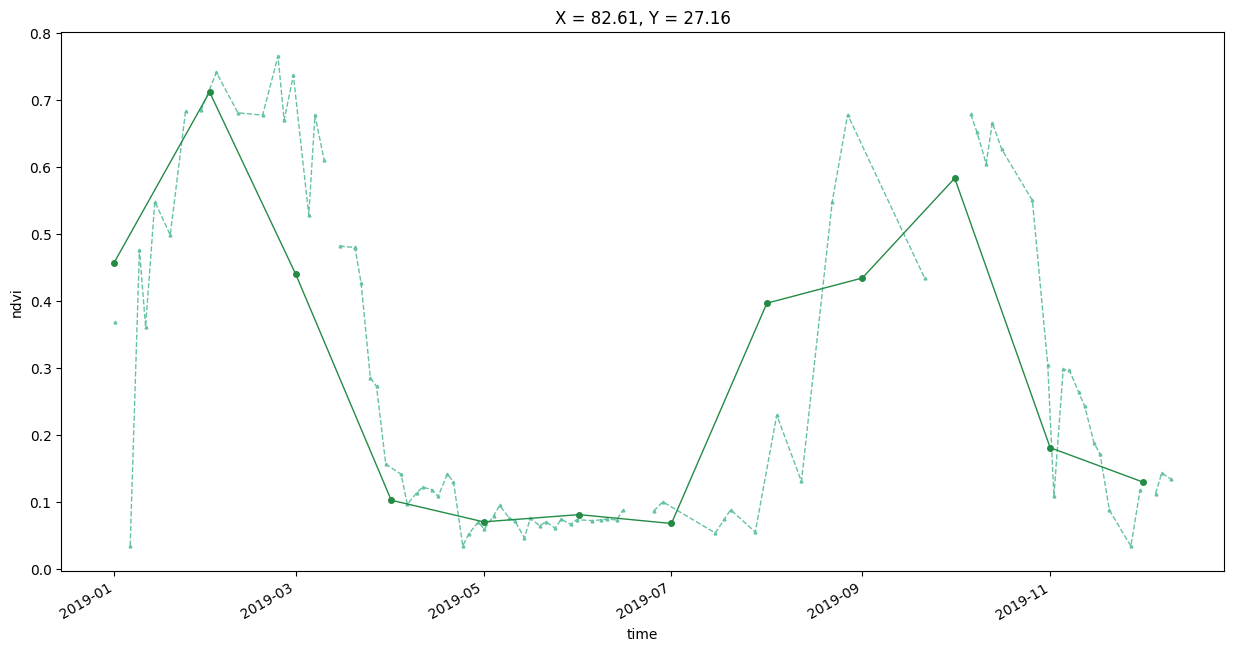

In [38]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)
original_ts.plot.line(
    ax=ax, x='time',
    marker='^', color='#66c2a4', linestyle='--', linewidth=1, markersize=2)
smooth_ts.plot.line(
    ax=ax, x='time',
    marker='o', color='#238b45', linestyle='-', linewidth=1, markersize=4)
plt.show()